In [3]:
#Import Python packages
import pandas as pd
import plotly.express as px
import json
import sys
import cachetools
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import json
import datetime

# for splitting of the dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

#ML-Models:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

# Connect to Snowflake

In [4]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [5]:
#Orders_V
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
#Customer Loyalty
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

In [6]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)
loyal_customer_orders.show()
print('Number of rows:',loyal_customer_orders.count())

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

In [8]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)
loyal_customer_orders.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK

In [9]:
#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])
remove_dup.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"      

# Add RFM column

In [10]:
#Get last purchase date as a variable
lastdate=tasty_bytes_orders_v.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = remove_dup.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = remove_dup.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = remove_dup.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')

In [11]:
RFM_table_df=RFM_table.to_pandas()

In [12]:
RFM_table_df=RFM_table_df.drop('ORDER_TS',axis=1,errors='ignore')

In [13]:
RFM_table_df.head()

,CUSTOMER_ID,RECENCY,FREQUENCY,MONETARY
0,85737,2,68,2924.00
1,58823,12,82,4052.00
2,196814,3,61,2366.00
3,71215,0,68,2342.50
4,8457,9,66,2374.25


In [15]:
X = RFM_table_df.drop("CUSTOMER_ID", axis=1)

# Scaling the data so that all the features/attributes become comparable 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 

In [16]:
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=300, random_state=1)

kmeans.fit(X_scaled)

KMeans(n_clusters=3, n_init=20, random_state=1)

In [22]:
# Evalute the model using Sum of Squared Errors (SSE) 
kmeans.inertia_

300287.52089355234

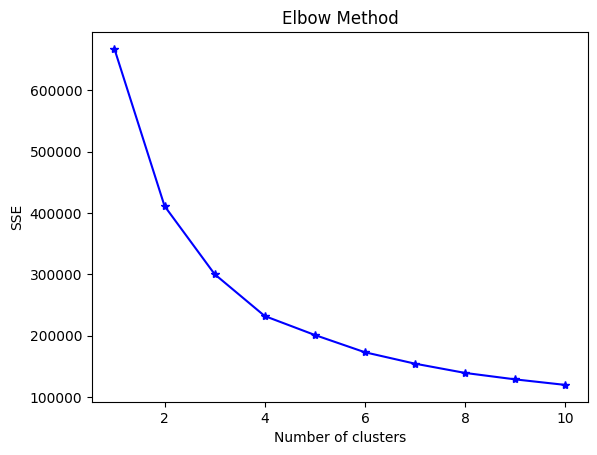

In [24]:
# Find the optimal number of clusters (i.e. K) using elbow method
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [30]:
kmeans = KMeans(n_clusters=5, n_init=20, max_iter=300, random_state=1)

kmeans.fit(X_scaled)

kmeans.inertia_

201136.89561465097

RECENCY


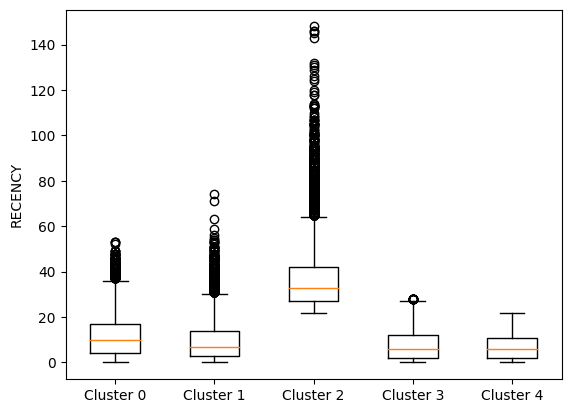

FREQUENCY


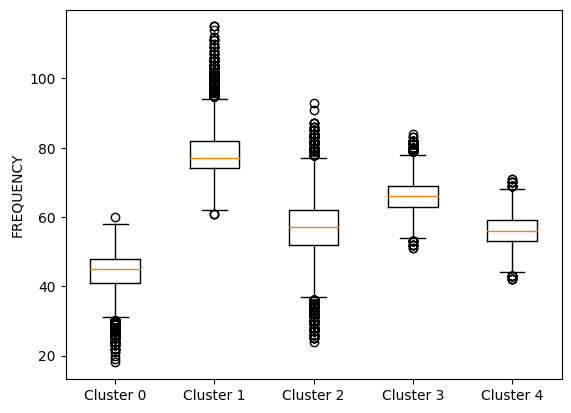

MONETARY


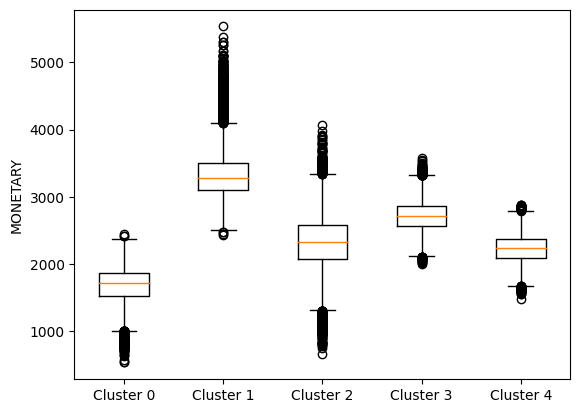

Cluster


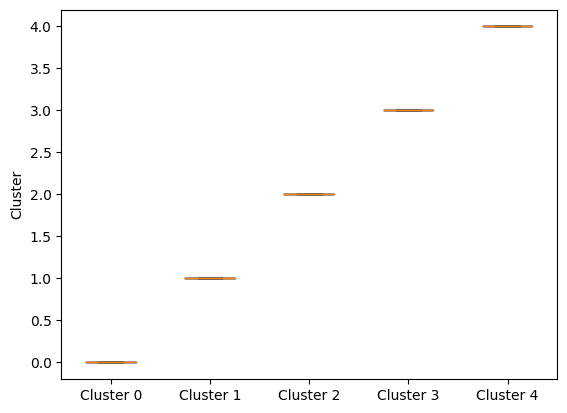

In [35]:
y_pred = kmeans.fit_predict(X_scaled)

X['Cluster']=y_pred

i=0
for col in X: 
    print(col) 
    plt.cla()
    plt.boxplot([X.iloc[:,i][X.Cluster==0].tolist(),
                 X.iloc[:,i][X.Cluster==1].tolist(),
                 X.iloc[:,i][X.Cluster==2].tolist(),
                 X.iloc[:,i][X.Cluster==3].tolist(),
                X.iloc[:,i][X.Cluster==4].tolist()],
                 labels=('Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'))    
    plt.ylabel(col)
    plt.show()
    i=i+1